In [93]:
import warnings
warnings.filterwarnings("ignore")

In [94]:
import time
start = time.time()

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.model_selection import cross_val_score,StratifiedKFold,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix,precision_score,f1_score,recall_score
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

plt.style.use('seaborn')

np.set_printoptions(precision=4)

In [96]:
x_train = pd.read_csv('./data_f1/ANNData/cleaned_data.csv')
x_test = pd.read_csv('./data_f1/ANNData/cleaned_data_2022.csv')

In [97]:
active_constructors = ['Alpine F1', 'Williams', 'McLaren', 'Ferrari', 'Mercedes',
                       'AlphaTauri', 'Aston Martin', 'Alfa Romeo', 'Red Bull',
                       'Haas F1 Team']
active_drivers = ['Daniel Ricciardo', 'Mick Schumacher', 'Carlos Sainz',
                  'Valtteri Bottas', 'Lance Stroll', 'George Russell',
                  'Lando Norris', 'Sebastian Vettel', 'Kimi Räikkönen',
                  'Charles Leclerc', 'Lewis Hamilton', 'Yuki Tsunoda',
                  'Max Verstappen', 'Pierre Gasly', 'Fernando Alonso',
                  'Sergio Pérez', 'Esteban Ocon', 'Antonio Giovinazzi',
                  'Nikita Mazepin','Nicholas Latifi']
x_train['active_driver'] = x_train['driver'].apply(lambda x: int(x in active_drivers))
x_train['active_constructor'] = x_train['constructor'].apply(lambda x: int(x in active_constructors))

In [98]:
active_constructors = ['Alpine F1', 'Williams', 'McLaren', 'Ferrari', 'Mercedes',
                       'AlphaTauri', 'Aston Martin', 'Alfa Romeo', 'Red Bull',
                       'Haas F1 Team']
active_drivers = ['Max Verstappen', 'Sergio Pérez', 'Fernando Alonso', 'Lewis Hamilton',
                  'George Russell', 'Carlos Sainz', 'Charles Leclerc', 'Lance Stroll',
                  'Esteban Ocon', 'Pierre Gasly', 'Lando Norris', 'Nico Hülkenberg', 
                  'Oscar Piastri', 'Valtteri Bottas', 'Guanyu Zhou', 'Yuki Tsunoda', 
                  'Kevin Magnussen', 'Alexander Albon', 'Logan Sargeant']
x_test['active_driver'] = x_test['driver'].apply(lambda x: int(x in active_drivers))
x_test['active_constructor'] = x_test['constructor'].apply(lambda x: int(x in active_constructors))

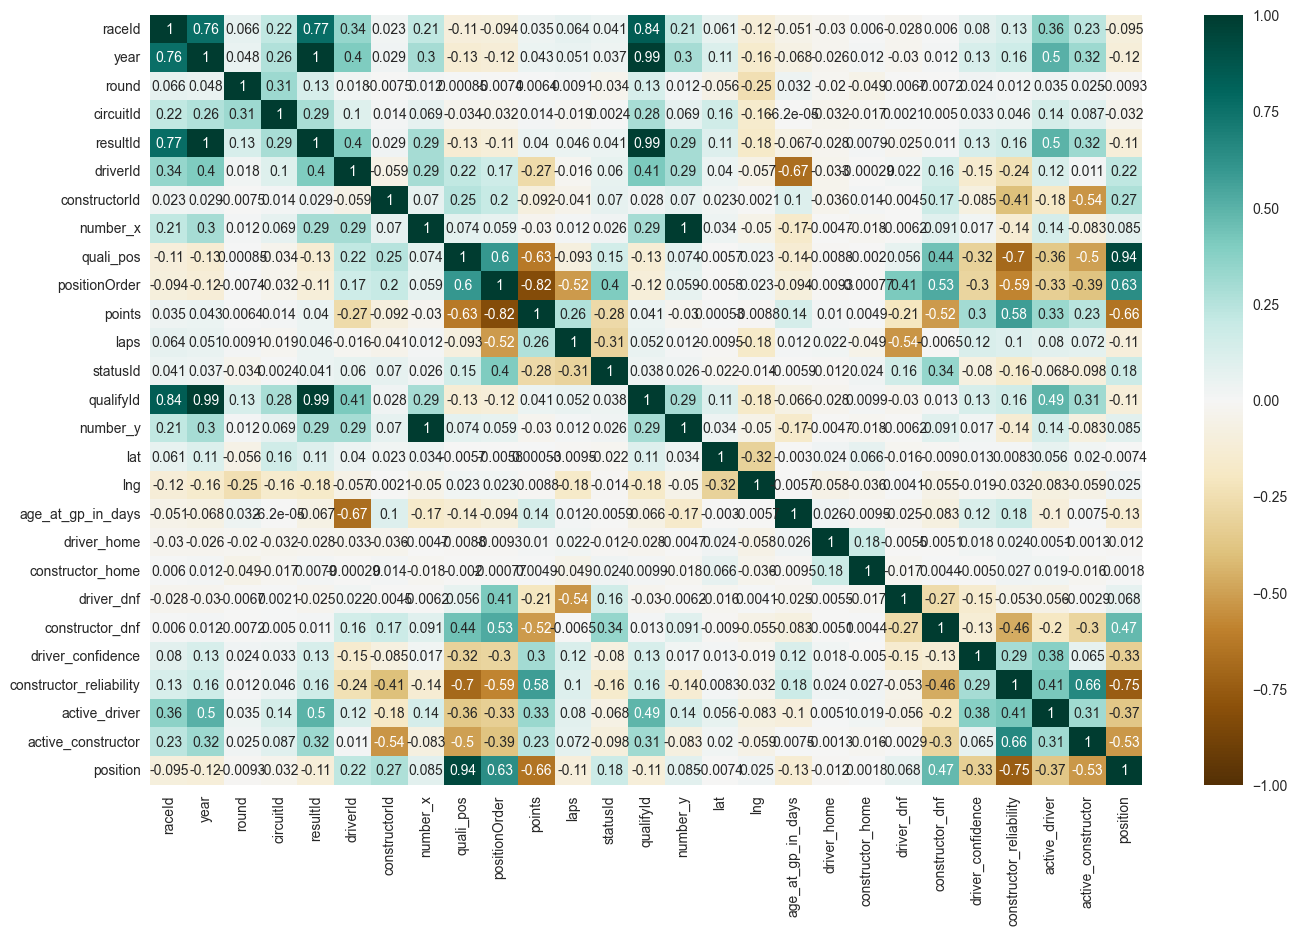

In [99]:
x = x_train[['raceId', 'year', 'round', 'circuitId', 'resultId', 'driverId', 'constructorId', 'number_x', 'quali_pos', 'positionOrder', 'points', 'laps', 'statusId', 'qualifyId', 'number_y', 'lat', 'lng', 'age_at_gp_in_days', 'driver_home', 'constructor_home', 'driver_dnf', 'constructor_dnf', 'driver_confidence', 'constructor_reliability', 'active_driver', 'active_constructor', 'position']]
plt.figure(figsize=(16, 10))
heatmap = sns.heatmap(x.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')

In [100]:
data_train = x_train[['age_at_gp_in_days','GP_name', 'constructor','driver', 'year', 'round', 'number_x', 'quali_pos', 'positionOrder', 'points', 'laps', 'number_y', 'lat', 'lng', 'driver_home', 'constructor_home', 'driver_dnf', 'constructor_dnf', 'driver_confidence', 'constructor_reliability', 'active_driver', 'active_constructor', 'position']]
data_test = x_test[['age_at_gp_in_days','GP_name', 'constructor','driver', 'year', 'round', 'number_x', 'quali_pos', 'positionOrder', 'points', 'laps', 'number_y', 'lat', 'lng', 'driver_home', 'constructor_home', 'driver_dnf', 'constructor_dnf', 'driver_confidence', 'constructor_reliability', 'active_driver', 'active_constructor', 'position']]

## Directory to store Models

In [101]:
import os
if not os.path.exists('./models'):
    os.mkdir('./models')

In [102]:
def position_index(x):
    if x<4:
        return 1
    if x>10:
        return 3
    else :
        return 2

## Model considering only Drivers

In [103]:
x_d_train= data_train
x_d_test= data_test

In [104]:
x_d_train = x_d_train[x_d_train['active_driver']==1]
x_d_test = x_d_test[x_d_test['active_driver']==1]

In [105]:
sc  = StandardScaler()
le = LabelEncoder()
x_d_train['GP_name'] = le.fit_transform(x_d_train['GP_name'])
x_d_train['driver'] = le.fit_transform(x_d_train['driver'])
x_d_train['age_at_gp_in_days'] = sc.fit_transform(x_d_train[['age_at_gp_in_days']])
X_d_train = x_d_train.drop(['position','active_driver', 'constructor'],axis=1)
y_d_train = x_d_train['position'].apply(lambda x: position_index(x))

In [106]:
sc  = StandardScaler()
le = LabelEncoder()
x_d_test['GP_name'] = le.fit_transform(x_d_test['GP_name'])
x_d_test['driver'] = le.fit_transform(x_d_test['driver'])
x_d_test['age_at_gp_in_days'] = sc.fit_transform(x_d_test[['age_at_gp_in_days']])
X_d_test = x_d_test.drop(['position','active_driver', 'constructor'],axis=1)
y_d_test = x_d_test['position'].apply(lambda x: position_index(x))

In [107]:
models = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier()]
names = ['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier']
model_dict = dict(zip(models,names))
ranking = []

for model in models:
    rfe = RFE(estimator=model, step=1, n_features_to_select=10)
    rfe = rfe.fit(X_d_train, y_d_train)
    ranking.append(rfe.ranking_)
    print(f'{model_dict[model]} : {rfe.ranking_}')



LogisticRegression : [ 1  1  1  6  1  4  1  1  1  1  2  3  5 10 11  7  1  9  1  8]
DecisionTreeClassifier : [ 1  1  1  1  1  5  1  1  3  1  6  4  1  9 10  7  8  2  1 11]
RandomForestClassifier : [ 1  4  1  3  1  1  1  1  1  2  5  6  1 10  9  8  7  1  1 11]


In [108]:
knn = KNeighborsClassifier(n_neighbors=3)
sfs = SequentialFeatureSelector(knn, n_features_to_select=10)
sfs.fit(X_d_train, y_d_train)
SequentialFeatureSelector(estimator=KNeighborsClassifier(n_neighbors=3),
                          n_features_to_select=7)
sfs.get_support()


array([ True, False,  True, False, False, False,  True, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True])

In [109]:
X_d_Lr_train = X_d_train[['GP_name', 'driver', 'age_at_gp_in_days', 'round', 'quali_pos', 'positionOrder', 'points', 'laps', 'constructor_reliability', 'constructor_dnf']]
X_d_Dt_train = X_d_train[['GP_name', 'driver', 'age_at_gp_in_days', 'year', 'round', 'quali_pos', 'positionOrder', 'laps', 'lng', 'number_y', 'constructor_reliability']]
X_d_Fc_train = X_d_train[['GP_name', 'driver', 'age_at_gp_in_days', 'year', 'round', 'quali_pos', 'positionOrder', 'points', 'laps', 'lng', 'driver_confidence', 'constructor_reliability']]
X_d_KNN_train = X_d_train[['GP_name', 'driver', 'age_at_gp_in_days', 'quali_pos', 'driver_home', 'constructor_home', 'driver_dnf', 'constructor_dnf', 'driver_confidence', 'constructor_reliability', 'active_constructor']]

In [110]:
X_d_Lr_test = X_d_test[['GP_name', 'driver', 'age_at_gp_in_days', 'round', 'quali_pos', 'positionOrder', 'points', 'laps', 'constructor_reliability', 'constructor_dnf']]
X_d_Dt_test = X_d_test[['GP_name', 'driver', 'age_at_gp_in_days', 'year', 'round', 'quali_pos', 'positionOrder', 'laps', 'lng', 'number_y', 'constructor_reliability']]
X_d_Fc_test = X_d_test[['GP_name', 'driver', 'age_at_gp_in_days', 'year', 'round', 'quali_pos', 'positionOrder', 'points', 'laps', 'lng', 'driver_confidence', 'constructor_reliability']]
X_d_KNN_test = X_d_test[['GP_name', 'driver', 'age_at_gp_in_days', 'quali_pos', 'driver_home', 'constructor_home', 'driver_dnf', 'constructor_dnf', 'driver_confidence', 'constructor_reliability', 'active_constructor']]

In [111]:
#fit for diffrent models
models = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),SVC(),GaussianNB(),KNeighborsClassifier()]
names = ['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier','SVC','GaussianNB','KNeighborsClassifier']
model_dict = dict(zip(models,names))

results_dri = []
name = []
for model in models:
   clf = model.fit(X_d_Lr_train, y_d_train)
   y_pred = clf.predict(X_d_Lr_test)

   acc = accuracy_score(y_d_test, y_pred)
   
   results_dri.append(acc)
   name.append(model_dict[model])
   print(f'{model_dict[model]} : {acc}')

LogisticRegression : 0.8016997167138811
DecisionTreeClassifier : 0.8385269121813032
RandomForestClassifier : 0.8980169971671388
SVC : 0.7790368271954674
GaussianNB : 0.7082152974504249
KNeighborsClassifier : 0.7365439093484419


In [112]:
#fit for diffrent models
models = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),SVC(),GaussianNB(),KNeighborsClassifier()]
names = ['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier','SVC','GaussianNB','KNeighborsClassifier']
model_dict = dict(zip(models,names))
results_dri = []
name = []
for model in models:
   clf = model.fit(X_d_Dt_train, y_d_train)
   y_pred = clf.predict(X_d_Dt_test)

   acc = accuracy_score(y_d_test, y_pred)
   
   results_dri.append(acc)
   name.append(model_dict[model])
   print(f'{model_dict[model]} : {acc}')

LogisticRegression : 0.71671388101983
DecisionTreeClassifier : 0.8130311614730878
RandomForestClassifier : 0.9008498583569405
SVC : 0.3881019830028329
GaussianNB : 0.7507082152974505
KNeighborsClassifier : 0.56657223796034


In [113]:
#fit for diffrent models
models = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),SVC(),GaussianNB(),KNeighborsClassifier()]
names = ['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier','SVC','GaussianNB','KNeighborsClassifier']
model_dict = dict(zip(models,names))

results_dri = []
name = []
for model in models:
   clf = model.fit(X_d_Fc_train, y_d_train)
   y_pred = clf.predict(X_d_Fc_test)

   acc = accuracy_score(y_d_test, y_pred)
   
   results_dri.append(acc)
   name.append(model_dict[model])
   print(f'{model_dict[model]} : {acc}')

LogisticRegression : 0.7365439093484419
DecisionTreeClassifier : 0.7620396600566572
RandomForestClassifier : 0.8781869688385269
SVC : 0.3881019830028329
GaussianNB : 0.7195467422096318
KNeighborsClassifier : 0.6742209631728046


In [114]:
#fit for diffrent models
models = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),SVC(),GaussianNB(),KNeighborsClassifier()]
names = ['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier','SVC','GaussianNB','KNeighborsClassifier']
model_dict = dict(zip(models,names))

results_dri = []
name = []
for model in models:
   clf = model.fit(X_d_KNN_train, y_d_train)
   y_pred = clf.predict(X_d_KNN_test)

   acc = accuracy_score(y_d_test, y_pred)
   
   results_dri.append(acc)
   name.append(model_dict[model])
   print(f'{model_dict[model]} : {acc}')

LogisticRegression : 0.8130311614730878
DecisionTreeClassifier : 0.7762039660056658
RandomForestClassifier : 0.886685552407932
SVC : 0.8555240793201133
GaussianNB : 0.5637393767705382
KNeighborsClassifier : 0.8130311614730878


In [115]:
# DRIVERS' SELECTED FEATURES
models = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),SVC(),GaussianNB(),KNeighborsClassifier()]
names = ['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier','SVC','GaussianNB','KNeighborsClassifier']
model_dict = dict(zip(models,names))

y_preds = []

results_dri = []
name = []
for model in models:
    if(model_dict[model] == 'RandomForestClassifier' or model_dict[model] == 'DecisionTreeClassifier' or model_dict[model] == 'SVC'): 
        X = X_d_Lr_train
        x_test = X_d_Lr_test
    elif(model_dict[model] == 'GaussianNB'):
        X = X_d_Dt_train
        x_test = X_d_Dt_test 
    else:
        X = X_d_KNN_train
        x_test = X_d_KNN_test

    clf = model.fit(X, y_d_train)
    y_pred = (clf.predict(x_test))
    y_preds.append(y_pred)
    
    acc = accuracy_score(y_d_test, y_pred)

    results_dri.append(acc)
    name.append(model_dict[model])
    print(f'{model_dict[model]} : {acc}')

LogisticRegression : 0.8130311614730878
DecisionTreeClassifier : 0.8271954674220963
RandomForestClassifier : 0.9036827195467422
SVC : 0.7790368271954674
GaussianNB : 0.7507082152974505
KNeighborsClassifier : 0.8130311614730878


In [116]:
model_acc = []

for i in range(6):
    cm = confusion_matrix(y_d_test, y_preds[i])

    model_acc.append(cm.diagonal()/cm.sum(axis=1))


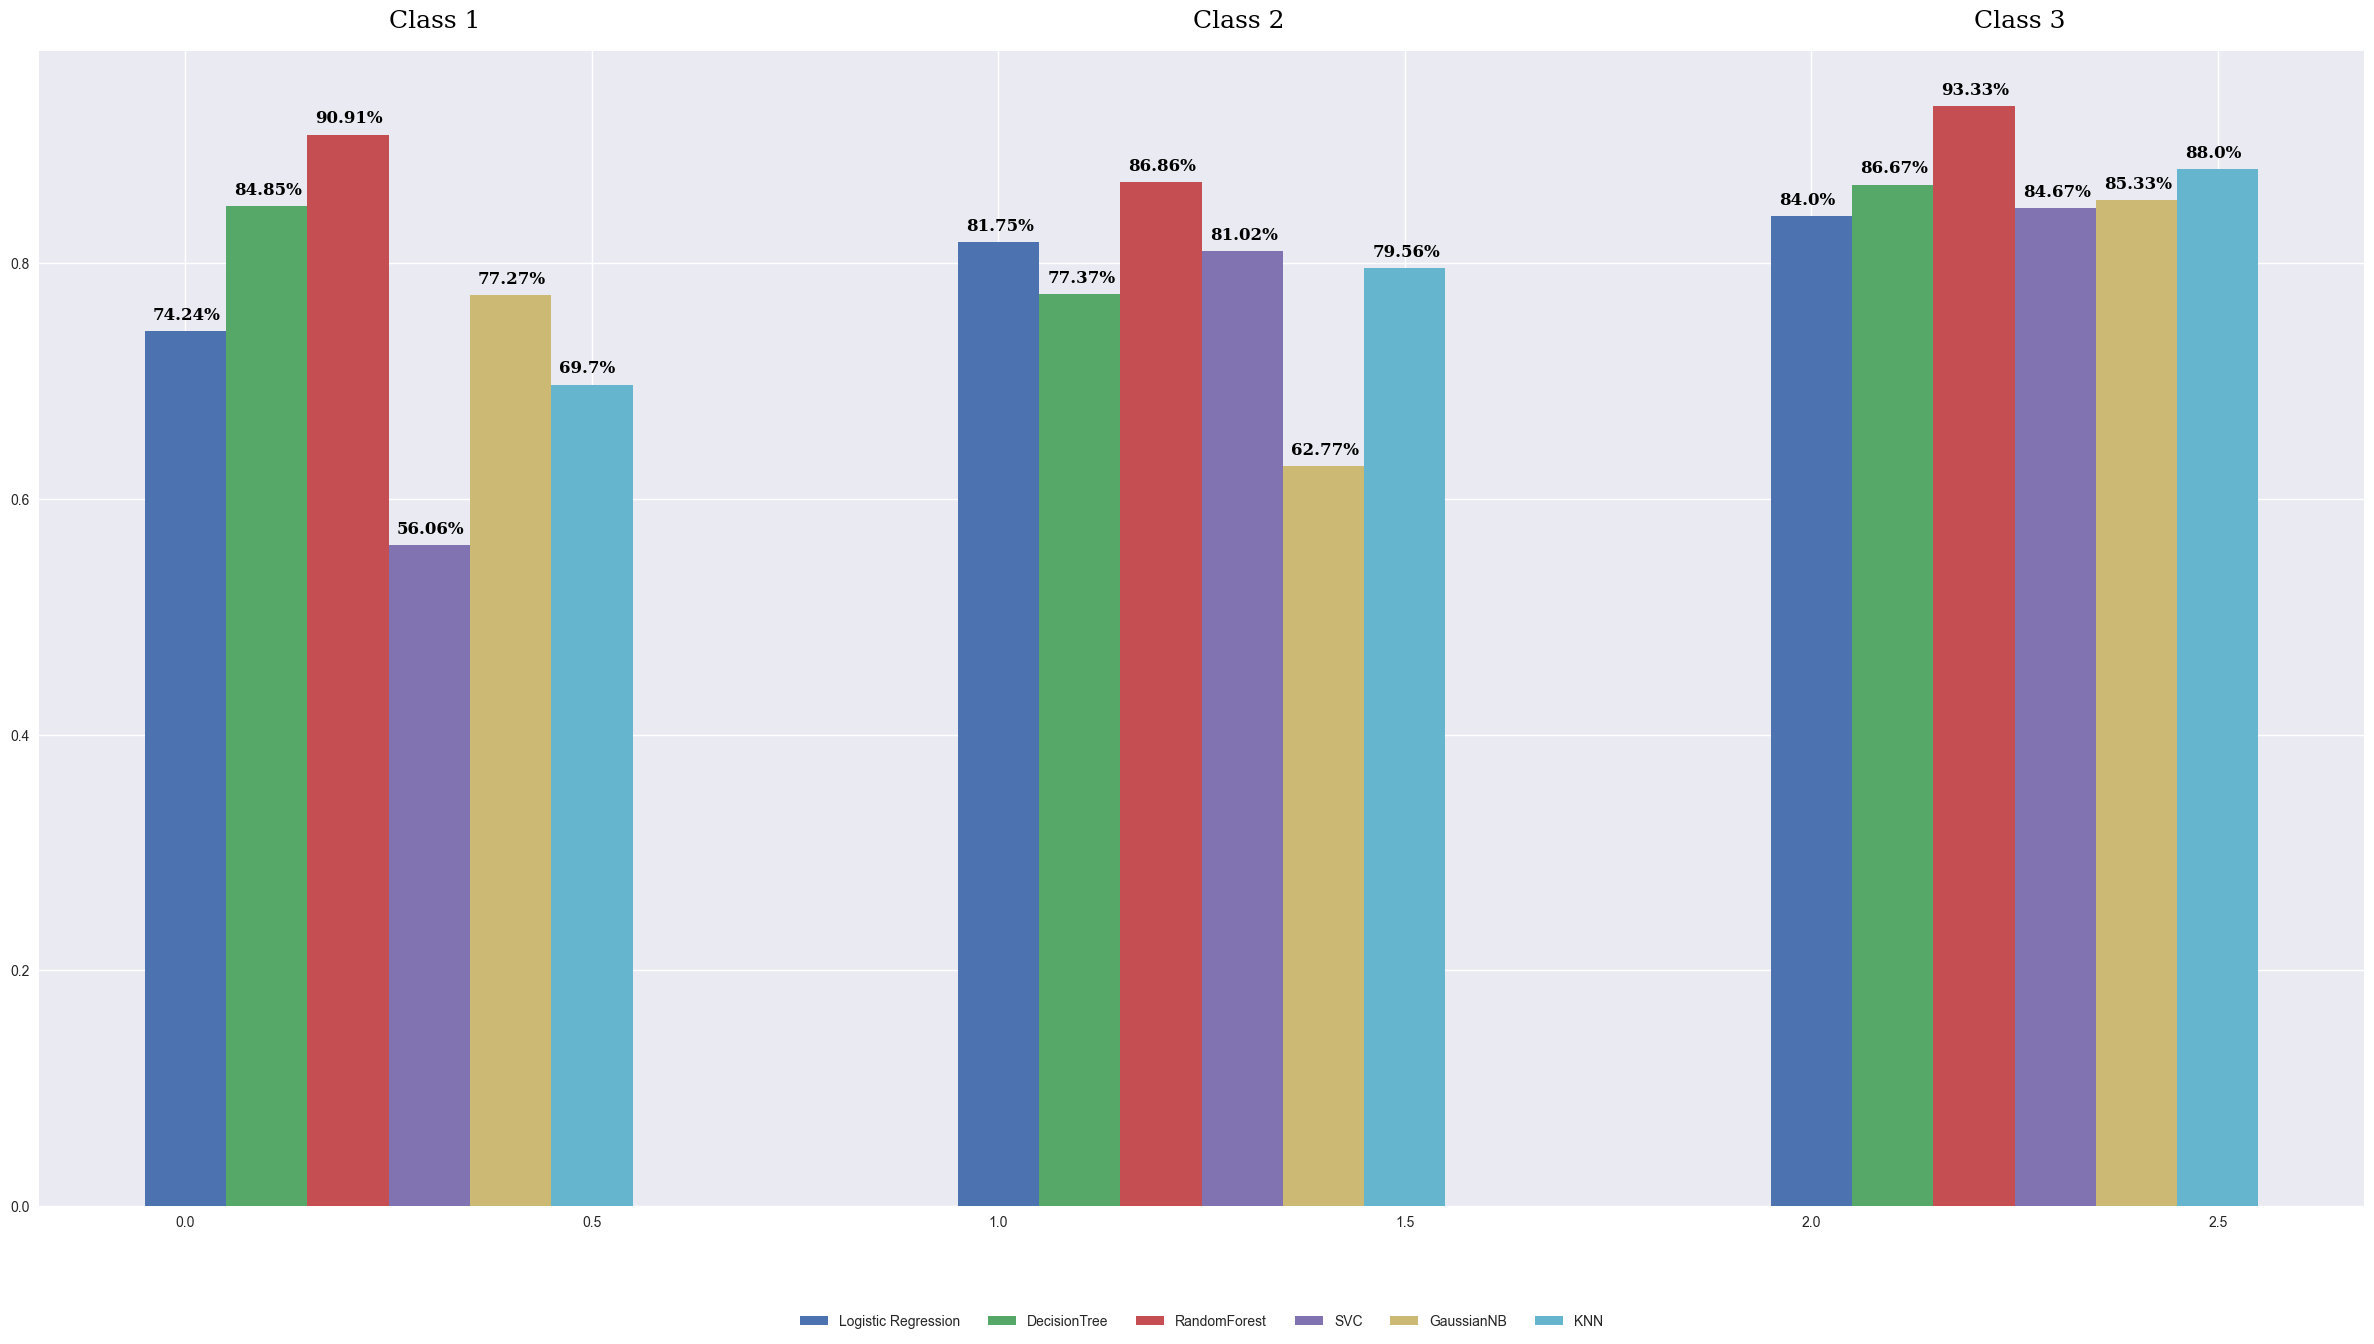

In [117]:
lr = [model_acc[0][0],model_acc[0][1],model_acc[0][2]]
dtc = [model_acc[1][0],model_acc[1][1],model_acc[1][2]]
rfc = [model_acc[2][0],model_acc[2][1],model_acc[2][2]]
svc = [model_acc[3][0],model_acc[3][1],model_acc[3][2]]
gnb = [model_acc[4][0],model_acc[4][1],model_acc[4][2]]
knn = [model_acc[5][0],model_acc[5][1],model_acc[5][2]]
font1 = {
    'family':'serif',
    'color':'black',
    'weight':'normal',
    'size':18
}
font2 = {
    'family':'serif',
    'color':'black',
    'weight':'bold',
    'size':12
}
x_ax = np.arange(3)
plt.figure(figsize=(30,15))
bar1 = plt.bar(x_ax,lr,width=0.1,align='center', label="Logistic Regression")
bar2 = plt.bar(x_ax+0.1,dtc,width=0.1,align='center', label="DecisionTree")
bar3 = plt.bar(x_ax+0.2,rfc,width=0.1,align='center',  label="RandomForest")
bar4 = plt.bar(x_ax+0.3,svc,width=0.1,align='center', label="SVC")
bar5 = plt.bar(x_ax+0.4,gnb,width=0.1,align='center', label="GaussianNB")
bar6 = plt.bar(x_ax+0.5,knn,width=0.1,align='center', label="KNN")
plt.text(0.25,1,'Class 1',fontdict=font1)
plt.text(1.24,1,'Class 2',fontdict=font1)
plt.text(2.2,1,'Class 3',fontdict=font1)
for bar in bar1.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar2.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar3.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar4.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar5.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar6.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.10), shadow=False, ncol=6)

plt.show()

## Model considering only Constructors

In [118]:
x_c_train= data_train
x_c_test= data_test

In [119]:
x_c_train = x_c_train[x_c_train['active_constructor']==1]
x_c_test = x_c_test[x_c_test['active_constructor']==1]

In [120]:
sc  = StandardScaler()
le = LabelEncoder()
x_c_train['GP_name'] = le.fit_transform(x_c_train['GP_name'])
x_c_train['constructor'] = le.fit_transform(x_c_train['constructor'])
x_c_train['age_at_gp_in_days'] = sc.fit_transform(x_c_train[['age_at_gp_in_days']])
X_c_train = x_c_train.drop(['position','active_constructor', 'driver'],axis=1)
y_c_train = x_c_train['position'].apply(lambda x: position_index(x))

In [121]:
sc  = StandardScaler()
le = LabelEncoder()
x_c_test['GP_name'] = le.fit_transform(x_c_test['GP_name'])
x_c_test['constructor'] = le.fit_transform(x_c_test['constructor'])
x_c_test['age_at_gp_in_days'] = sc.fit_transform(x_c_test[['age_at_gp_in_days']])
X_c_test = x_c_test.drop(['position','active_constructor', 'driver'],axis=1)
y_c_test = x_c_test['position'].apply(lambda x: position_index(x))

In [122]:
models = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier()]
names = ['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier']
model_dict = dict(zip(models,names))
ranking = []

for model in models:
    rfe = RFE(estimator=model, step=1, n_features_to_select=10)
    rfe = rfe.fit(X_c_train, y_c_train)
    ranking.append(rfe.ranking_)
    print(f'{model_dict[model]} : {rfe.ranking_}')



LogisticRegression : [ 1  2  1  6  1  5  1  1  1  1  3  4  7 10 11  9  1  8  1  1]
DecisionTreeClassifier : [ 1  2  3  1  1  6  1  1  5  1  1  4  1  7 11  8  9  1  1 10]
RandomForestClassifier : [ 1  5  1  2  4  1  1  1  1  1  3  6  1 11 10  9  7  1  1  8]


In [123]:
knn = KNeighborsClassifier(n_neighbors=3)
sfs = SequentialFeatureSelector(knn, n_features_to_select=10)
sfs.fit(X_c_train, y_c_train)
SequentialFeatureSelector(estimator=KNeighborsClassifier(n_neighbors=3),
                          n_features_to_select=7)
sfs.get_support()


array([ True, False, False,  True, False, False,  True, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True])

In [124]:
X_c_Lr_train = X_c_train[['GP_name', 'constructor', 'age_at_gp_in_days', 'quali_pos', 'positionOrder', 'points', 'laps', 'number_y', 'lat', 'constructor_reliability', 'constructor_dnf']]
X_c_Dt_train = X_c_train[['GP_name', 'constructor', 'age_at_gp_in_days', 'year', 'round', 'number_x', 'quali_pos', 'positionOrder', 'lng', 'driver_confidence', 'constructor_reliability']]
X_c_Fc_train = X_c_train[['GP_name', 'constructor', 'age_at_gp_in_days', 'year', 'number_x', 'quali_pos', 'positionOrder', 'points', 'laps', 'lng', 'driver_confidence', 'constructor_reliability']]
X_c_KNN_train = X_c_train[['GP_name', 'constructor', 'age_at_gp_in_days', 'year', 'quali_pos', 'driver_home', 'constructor_home', 'driver_dnf', 'constructor_dnf', 'driver_confidence', 'constructor_reliability', 'active_driver']]

In [125]:
X_c_Lr_test = X_c_test[['GP_name', 'constructor', 'age_at_gp_in_days', 'quali_pos', 'positionOrder', 'points', 'laps', 'number_y', 'lat', 'constructor_reliability', 'constructor_dnf']]
X_c_Dt_test = X_c_test[['GP_name', 'constructor', 'age_at_gp_in_days', 'year', 'round', 'number_x', 'quali_pos', 'positionOrder', 'lng', 'driver_confidence', 'constructor_reliability']]
X_c_Fc_test = X_c_test[['GP_name', 'constructor', 'age_at_gp_in_days', 'year', 'number_x', 'quali_pos', 'positionOrder', 'points', 'laps', 'lng', 'driver_confidence', 'constructor_reliability']]
X_c_KNN_test = X_c_test[['GP_name', 'constructor', 'age_at_gp_in_days', 'year', 'quali_pos', 'driver_home', 'constructor_home', 'driver_dnf', 'constructor_dnf', 'driver_confidence', 'constructor_reliability', 'active_driver']]

In [126]:
#fit for diffrent models
models = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),SVC(),GaussianNB(),KNeighborsClassifier()]
names = ['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier','SVC','GaussianNB','KNeighborsClassifier']
model_dict = dict(zip(models,names))

results_dri = []
name = []
for model in models:
   clf = model.fit(X_c_Lr_train, y_c_train)
   y_pred = clf.predict(X_c_Lr_test)

   acc = accuracy_score(y_c_test, y_pred)
   
   results_dri.append(acc)
   name.append(model_dict[model])
   print(f'{model_dict[model]} : {acc}')

LogisticRegression : 0.8159090909090909
DecisionTreeClassifier : 0.8477272727272728
RandomForestClassifier : 0.8954545454545455
SVC : 0.7863636363636364
GaussianNB : 0.7068181818181818
KNeighborsClassifier : 0.6818181818181818


In [127]:
#fit for diffrent models
models = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),SVC(),GaussianNB(),KNeighborsClassifier()]
names = ['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier','SVC','GaussianNB','KNeighborsClassifier']
model_dict = dict(zip(models,names))
results_dri = []
name = []
for model in models:
   clf = model.fit(X_c_Dt_train, y_c_train)
   y_pred = clf.predict(X_c_Dt_test)

   acc = accuracy_score(y_c_test, y_pred)
   
   results_dri.append(acc)
   name.append(model_dict[model])
   print(f'{model_dict[model]} : {acc}')

LogisticRegression : 0.7272727272727273
DecisionTreeClassifier : 0.759090909090909
RandomForestClassifier : 0.884090909090909
SVC : 0.5
GaussianNB : 0.7204545454545455
KNeighborsClassifier : 0.6590909090909091


In [128]:
#fit for diffrent models
models = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),SVC(),GaussianNB(),KNeighborsClassifier()]
names = ['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier','SVC','GaussianNB','KNeighborsClassifier']
model_dict = dict(zip(models,names))

results_dri = []
name = []
for model in models:
   clf = model.fit(X_c_Fc_train, y_c_train)
   y_pred = clf.predict(X_c_Fc_test)

   acc = accuracy_score(y_c_test, y_pred)
   
   results_dri.append(acc)
   name.append(model_dict[model])
   print(f'{model_dict[model]} : {acc}')

LogisticRegression : 0.7386363636363636
DecisionTreeClassifier : 0.7863636363636364
RandomForestClassifier : 0.875
SVC : 0.5
GaussianNB : 0.7
KNeighborsClassifier : 0.6886363636363636


In [129]:
#fit for diffrent models
models = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),SVC(),GaussianNB(),KNeighborsClassifier()]
names = ['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier','SVC','GaussianNB','KNeighborsClassifier']
model_dict = dict(zip(models,names))

results_dri = []
name = []
for model in models:
   clf = model.fit(X_c_KNN_train, y_c_train)
   y_pred = clf.predict(X_c_KNN_test)

   acc = accuracy_score(y_c_test, y_pred)
   
   results_dri.append(acc)
   name.append(model_dict[model])
   print(f'{model_dict[model]} : {acc}')

LogisticRegression : 0.8568181818181818
DecisionTreeClassifier : 0.6954545454545454
RandomForestClassifier : 0.8545454545454545
SVC : 0.5
GaussianNB : 0.7
KNeighborsClassifier : 0.8022727272727272


In [130]:
# CONSTRUCTORS' SELECTED FEATURES
models = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),SVC(),GaussianNB(),KNeighborsClassifier()]
names = ['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier','SVC','GaussianNB','KNeighborsClassifier']
model_dict = dict(zip(models,names))

y_preds = []

results_dri = []
name = []
for model in models:
    if(model_dict[model] == 'RandomForestClassifier' or model_dict[model] == 'DecisionTreeClassifier' or model_dict[model] == 'SVC'): 
        X = X_c_Lr_train
        x_test = X_c_Lr_test
    elif(model_dict[model] == 'GaussianNB'):
        X = X_c_Dt_train
        x_test = X_c_Dt_test 
    else:
        X = X_c_KNN_train
        x_test = X_c_KNN_test

    clf = model.fit(X, y_c_train)
    y_pred = (clf.predict(x_test))
    y_preds.append(y_pred)
    
    acc = accuracy_score(y_c_test, y_pred)

    results_dri.append(acc)
    name.append(model_dict[model])
    print(f'{model_dict[model]} : {acc}')

LogisticRegression : 0.8568181818181818
DecisionTreeClassifier : 0.8522727272727273
RandomForestClassifier : 0.8909090909090909
SVC : 0.7863636363636364
GaussianNB : 0.7204545454545455
KNeighborsClassifier : 0.8022727272727272


In [131]:
model_acc = []

for i in range(6):
    cm = confusion_matrix(y_c_test, y_preds[i])

    model_acc.append(cm.diagonal()/cm.sum(axis=1))


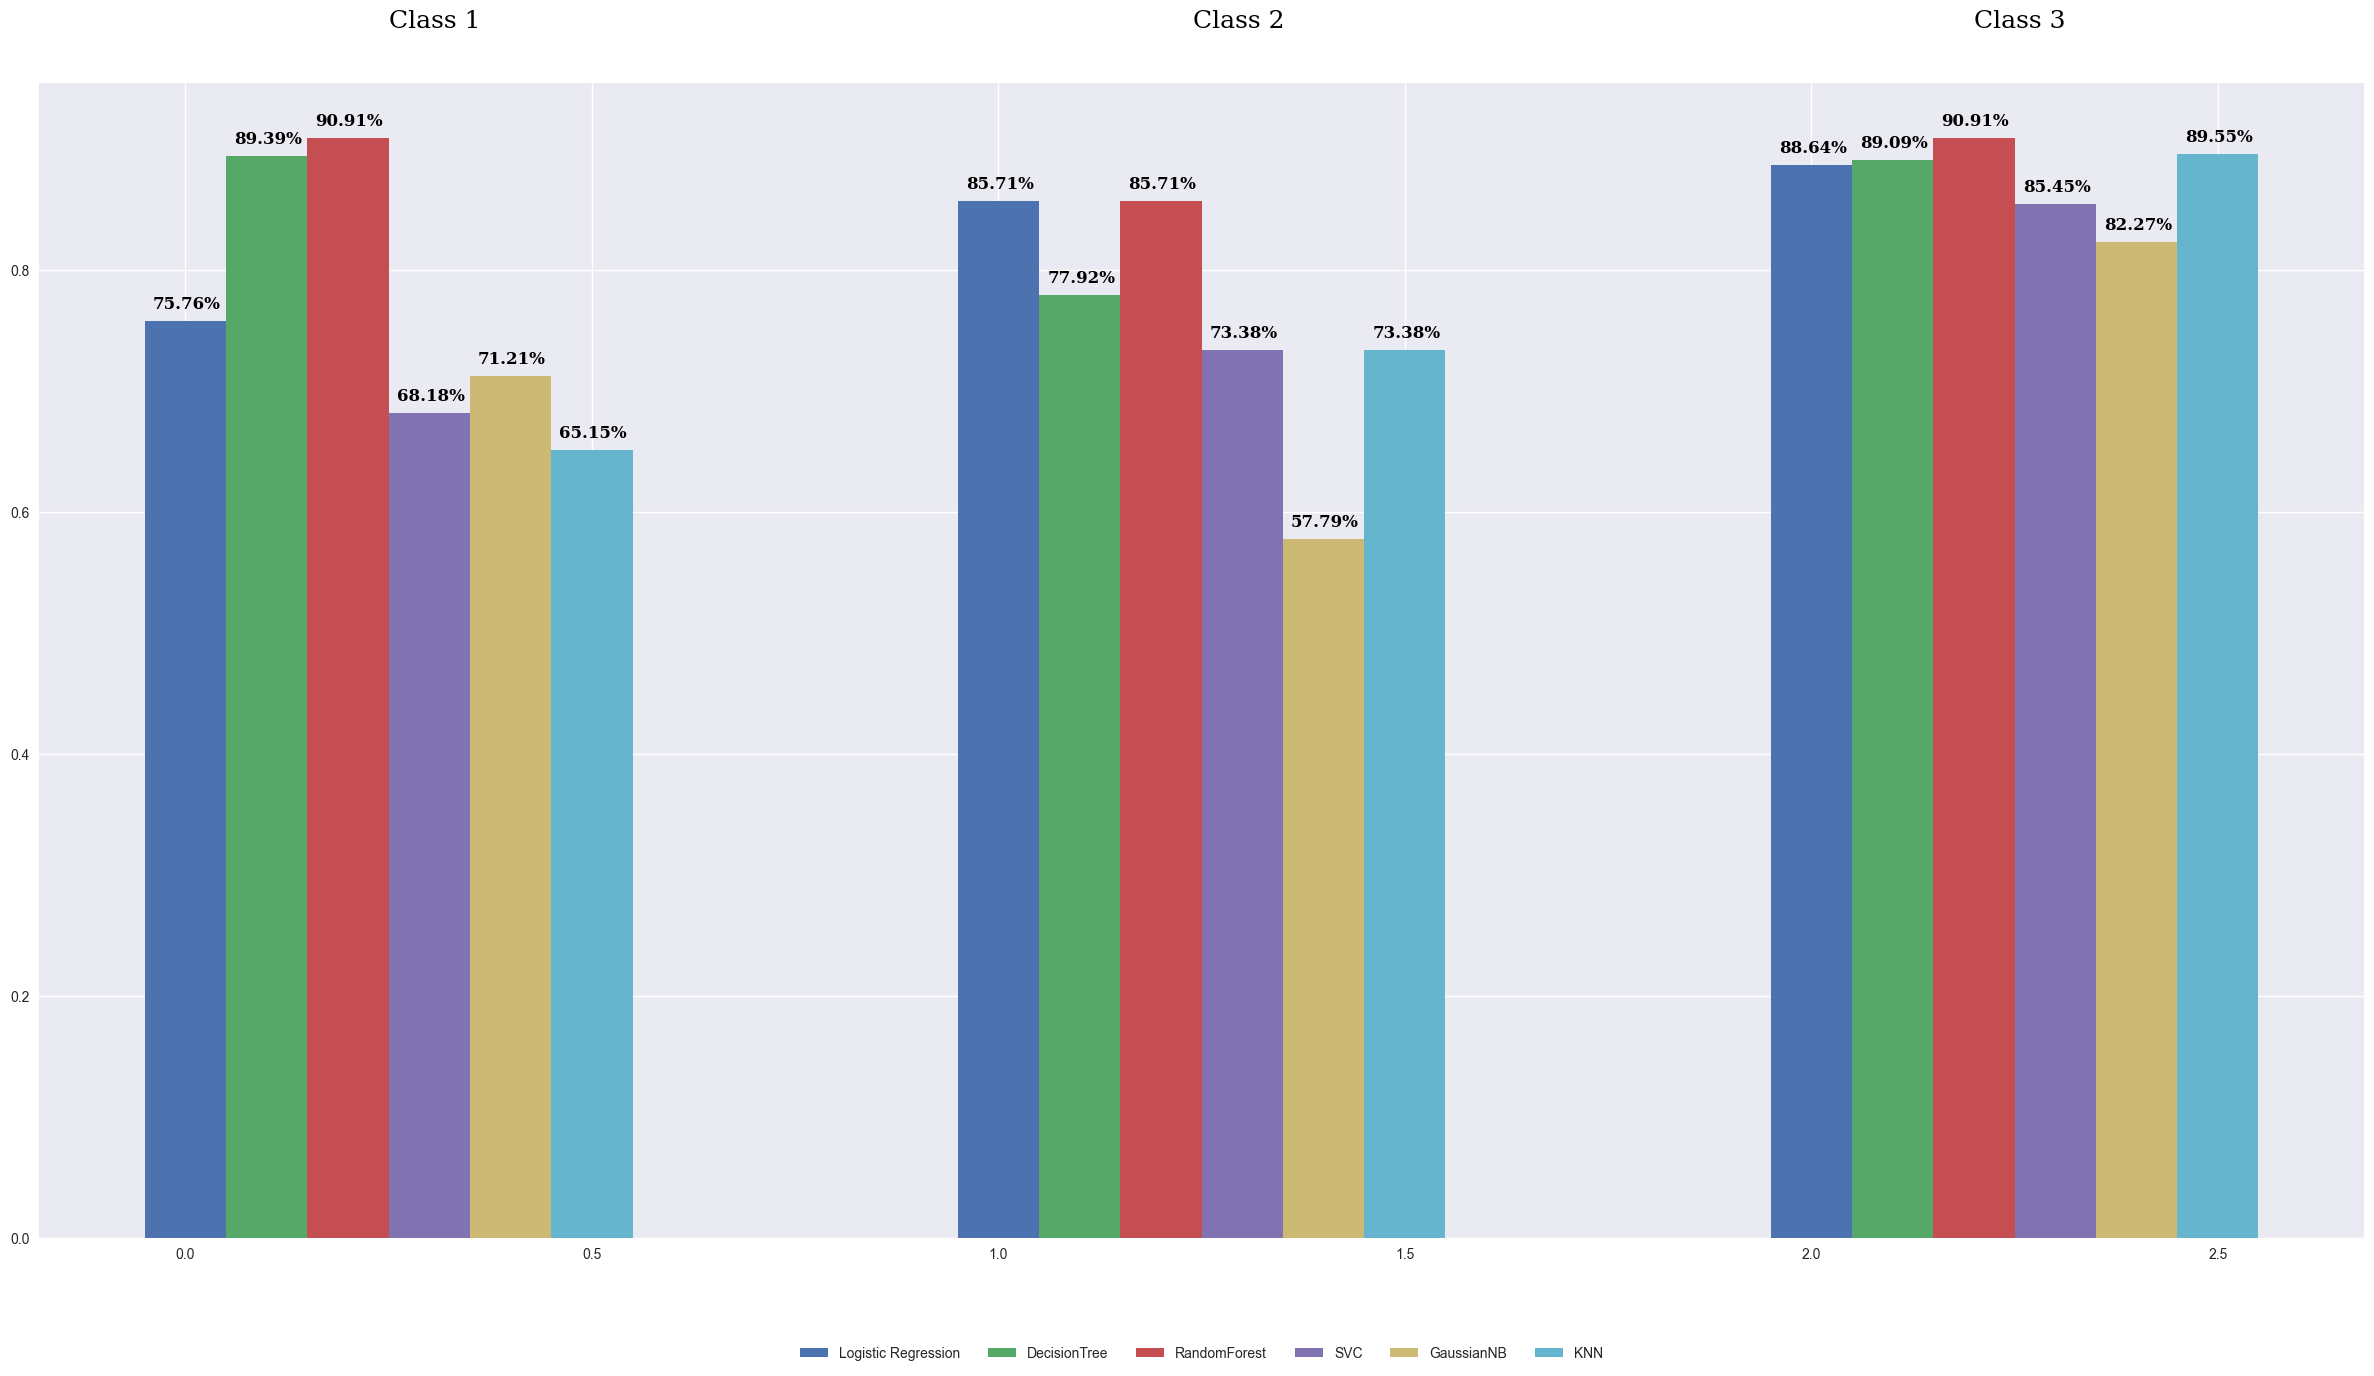

In [132]:
lr = [model_acc[0][0],model_acc[0][1],model_acc[0][2]]
dtc = [model_acc[1][0],model_acc[1][1],model_acc[1][2]]
rfc = [model_acc[2][0],model_acc[2][1],model_acc[2][2]]
svc = [model_acc[3][0],model_acc[3][1],model_acc[3][2]]
gnb = [model_acc[4][0],model_acc[4][1],model_acc[4][2]]
knn = [model_acc[5][0],model_acc[5][1],model_acc[5][2]]
font1 = {
    'family':'serif',
    'color':'black',
    'weight':'normal',
    'size':18
}
font2 = {
    'family':'serif',
    'color':'black',
    'weight':'bold',
    'size':12
}
x_ax = np.arange(3)
plt.figure(figsize=(30,15))
bar1 = plt.bar(x_ax,lr,width=0.1,align='center', label="Logistic Regression")
bar2 = plt.bar(x_ax+0.1,dtc,width=0.1,align='center', label="DecisionTree")
bar3 = plt.bar(x_ax+0.2,rfc,width=0.1,align='center',  label="RandomForest")
bar4 = plt.bar(x_ax+0.3,svc,width=0.1,align='center', label="SVC")
bar5 = plt.bar(x_ax+0.4,gnb,width=0.1,align='center', label="GaussianNB")
bar6 = plt.bar(x_ax+0.5,knn,width=0.1,align='center', label="KNN")
plt.text(0.25,1,'Class 1',fontdict=font1)
plt.text(1.24,1,'Class 2',fontdict=font1)
plt.text(2.2,1,'Class 3',fontdict=font1)
for bar in bar1.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar2.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar3.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar4.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar5.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar6.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.10), shadow=False, ncol=6)

plt.show()

# Model considering both Drivers and Constructors

In [133]:
x_dc_train = data_train[['position', 'active_constructor', 'active_driver', 'GP_name', 'driver', 'age_at_gp_in_days', 'round', 'quali_pos', 'positionOrder', 'points', 'laps', 'constructor_reliability', 'constructor_dnf', 'constructor', 'number_y', 'lat' ]]
x_dc_train = x_dc_train[(x_dc_train['active_driver']==1)&(x_dc_train['active_constructor']==1)]

x_dc_test = data_test[['position', 'active_constructor', 'active_driver', 'GP_name', 'driver', 'age_at_gp_in_days', 'round', 'quali_pos', 'positionOrder', 'points', 'laps', 'constructor_reliability', 'constructor_dnf', 'constructor', 'number_y', 'lat' ]]
x_dc_test = x_dc_test[(x_dc_test['active_driver']==1)&(x_dc_test['active_constructor']==1)]


In [134]:
sc  = StandardScaler()
le = LabelEncoder()

x_dc_train['GP_name'] = le.fit_transform(x_dc_train['GP_name'])
x_dc_train['driver'] = le.fit_transform(x_dc_train['driver'])
x_dc_train['constructor'] = le.fit_transform(x_dc_train['constructor'])
x_dc_train['age_at_gp_in_days'] = sc.fit_transform(x_dc_train[['age_at_gp_in_days']])
X_dc_train = x_dc_train.drop(['position','active_constructor', 'active_driver'],axis=1)
y_dc_train = x_dc_train['position'].apply(lambda x: position_index(x))

In [135]:
sc  = StandardScaler()
le = LabelEncoder()
x_dc_test['GP_name'] = le.fit_transform(x_dc_test['GP_name'])
x_dc_test['driver'] = le.fit_transform(x_dc_test['driver'])
x_dc_test['constructor'] = le.fit_transform(x_dc_test['constructor'])
x_dc_test['age_at_gp_in_days'] = sc.fit_transform(x_dc_test[['age_at_gp_in_days']])
X_dc_test = x_dc_test.drop(['position','active_constructor', 'active_driver'],axis=1)
y_dc_test = x_dc_test['position'].apply(lambda x: position_index(x))

In [136]:
# CONSTRUCTORS' SELECTED FEATURES
models = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),SVC(),GaussianNB(),KNeighborsClassifier()]
names = ['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier','SVC','GaussianNB','KNeighborsClassifier']
model_dict = dict(zip(models,names))

y_preds = []

results_dri = []
name = []
for model in models:
    clf = model.fit(X_dc_train, y_dc_train)
    y_pred = (clf.predict(X_dc_test))
    y_preds.append(y_pred)
    
    acc = accuracy_score(y_dc_test, y_pred)

    results_dri.append(acc)
    name.append(model_dict[model])
    print(f'{model_dict[model]} : {acc}')

LogisticRegression : 0.7988668555240793
DecisionTreeClassifier : 0.8725212464589235
RandomForestClassifier : 0.8923512747875354
SVC : 0.7337110481586402
GaussianNB : 0.6827195467422096
KNeighborsClassifier : 0.6345609065155807


In [137]:
model_acc = []

for i in range(6):
    cm = confusion_matrix(y_dc_test, y_preds[i])

    model_acc.append(cm.diagonal()/cm.sum(axis=1))


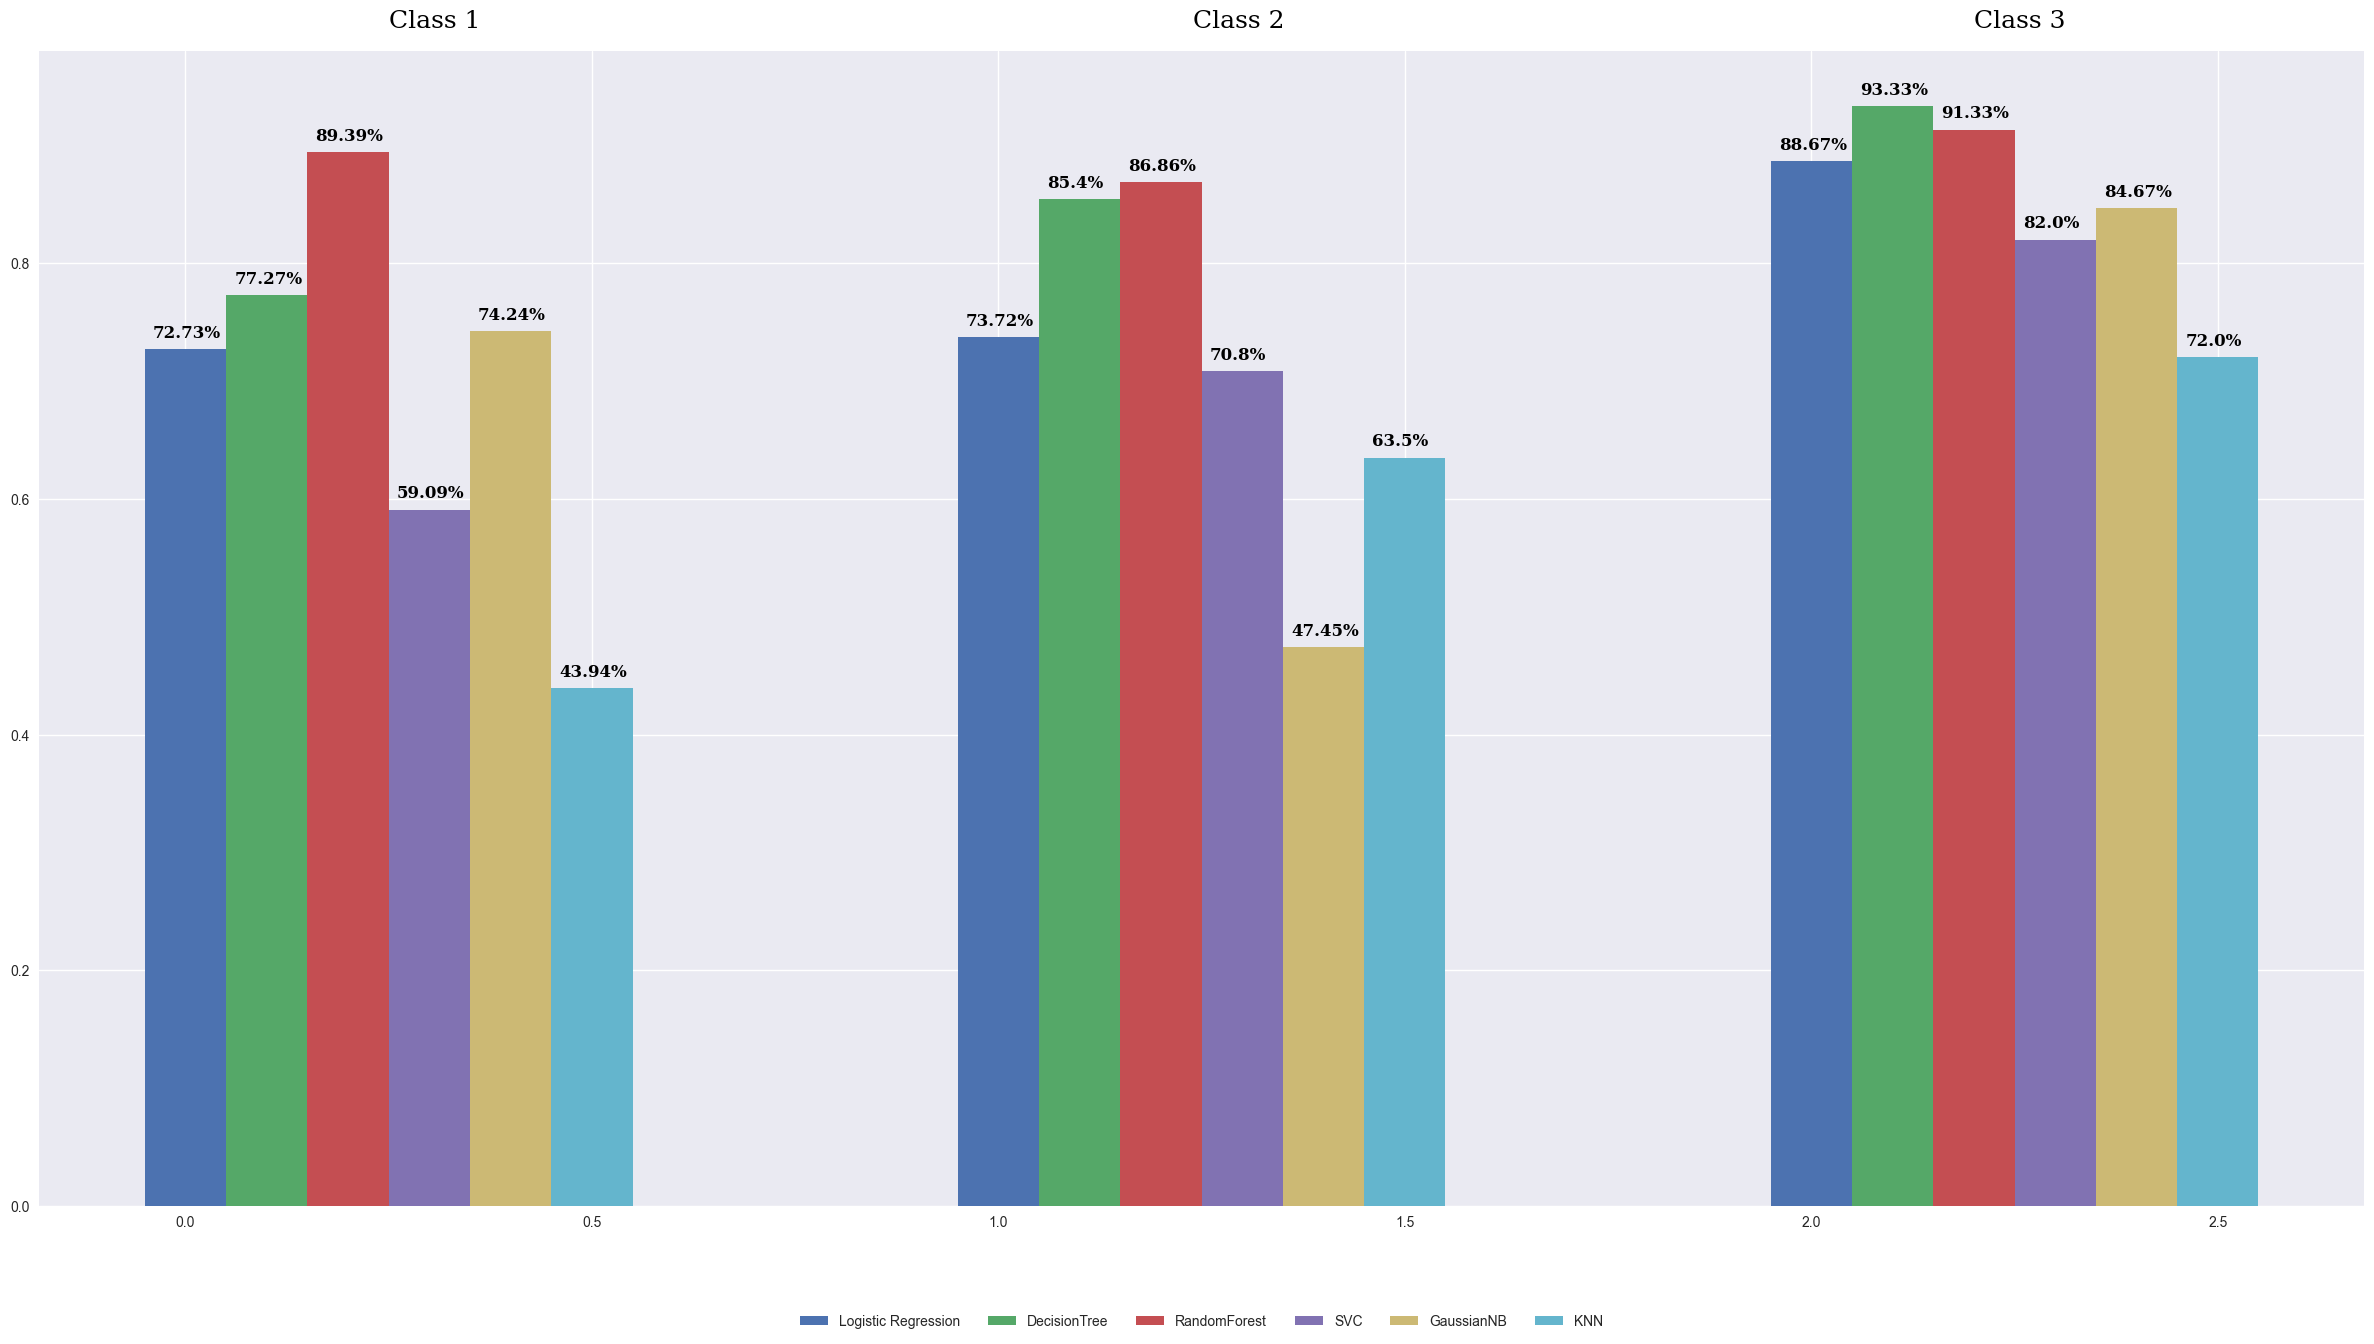

In [138]:
lr = [model_acc[0][0],model_acc[0][1],model_acc[0][2]]
dtc = [model_acc[1][0],model_acc[1][1],model_acc[1][2]]
rfc = [model_acc[2][0],model_acc[2][1],model_acc[2][2]]
svc = [model_acc[3][0],model_acc[3][1],model_acc[3][2]]
gnb = [model_acc[4][0],model_acc[4][1],model_acc[4][2]]
knn = [model_acc[5][0],model_acc[5][1],model_acc[5][2]]
font1 = {
    'family':'serif',
    'color':'black',
    'weight':'normal',
    'size':18
}
font2 = {
    'family':'serif',
    'color':'black',
    'weight':'bold',
    'size':12
}
x_ax = np.arange(3)
plt.figure(figsize=(30,15))
bar1 = plt.bar(x_ax,lr,width=0.1,align='center', label="Logistic Regression")
bar2 = plt.bar(x_ax+0.1,dtc,width=0.1,align='center', label="DecisionTree")
bar3 = plt.bar(x_ax+0.2,rfc,width=0.1,align='center',  label="RandomForest")
bar4 = plt.bar(x_ax+0.3,svc,width=0.1,align='center', label="SVC")
bar5 = plt.bar(x_ax+0.4,gnb,width=0.1,align='center', label="GaussianNB")
bar6 = plt.bar(x_ax+0.5,knn,width=0.1,align='center', label="KNN")
plt.text(0.25,1,'Class 1',fontdict=font1)
plt.text(1.24,1,'Class 2',fontdict=font1)
plt.text(2.2,1,'Class 3',fontdict=font1)
for bar in bar1.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar2.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar3.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar4.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar5.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar6.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.10), shadow=False, ncol=6)

plt.show()

## XGBOOST

In [139]:
le = LabelEncoder()

y_dc_train = le.fit_transform(y_dc_train)
y_dc_test = le.fit_transform(y_dc_test)

In [140]:
bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=0.5, objective='multi:softmax')
# fit model
#bst.fit(X_dc,y_dc)

clf = bst.fit(X_dc_train, y_dc_train)
y_pred = (clf.predict(X_dc_test))

    
acc = accuracy_score(y_dc_test, y_pred)
print(acc)

0.9065155807365439


In [141]:
param_grid = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(1, 400, 100),
    'learning_rate': [0.01],
    'objective': ['multi:softmax']
}

In [142]:
model = XGBClassifier()
scoring = 'accuracy'
grid_search = GridSearchCV(model, param_grid, scoring=scoring, cv=3, verbose=2)

In [143]:
grid_search.fit(X_dc_train,y_dc_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] END learning_rate=0.01, max_depth=2, n_estimators=1, objective=multi:softmax; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=1, objective=multi:softmax; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=1, objective=multi:softmax; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=101, objective=multi:softmax; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=101, objective=multi:softmax; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=101, objective=multi:softmax; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=201, objective=multi:softmax; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=201, objective=multi:softmax; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=201, objective=multi:softmax; total time=   0.2s
[CV] END 

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01], 'max_depth': range(2, 10),
                         'n_estimators': range(1, 400, 100),
                         'objective': ['multi:softmax']},
             scoring='accuracy', verbose=2)

In [144]:
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 101, 'objective': 'multi:softmax'}
Best score: 0.9416404495827785


In [145]:
# Re-train the model with the best hyperparameters
best_clf = grid_search.best_estimator_
best_clf.fit(X_dc_train,y_dc_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=101, n_jobs=None, num_parallel_tree=None,
              objective='multi:softmax', predictor=None, ...)

In [146]:
accuracy = best_clf.score(X_dc_test,y_dc_test)
print("Testing accuracy:", accuracy)

Testing accuracy: 0.9065155807365439


In [147]:

cm = confusion_matrix(y_dc_test, y_pred)
model_acc.append(cm.diagonal()/cm.sum(axis=1))


[array([0.7273, 0.7372, 0.8867]), array([0.7727, 0.854 , 0.9333]), array([0.8939, 0.8686, 0.9133]), array([0.5909, 0.708 , 0.82  ]), array([0.7424, 0.4745, 0.8467]), array([0.4394, 0.635 , 0.72  ]), array([0.9091, 0.8613, 0.9467])]


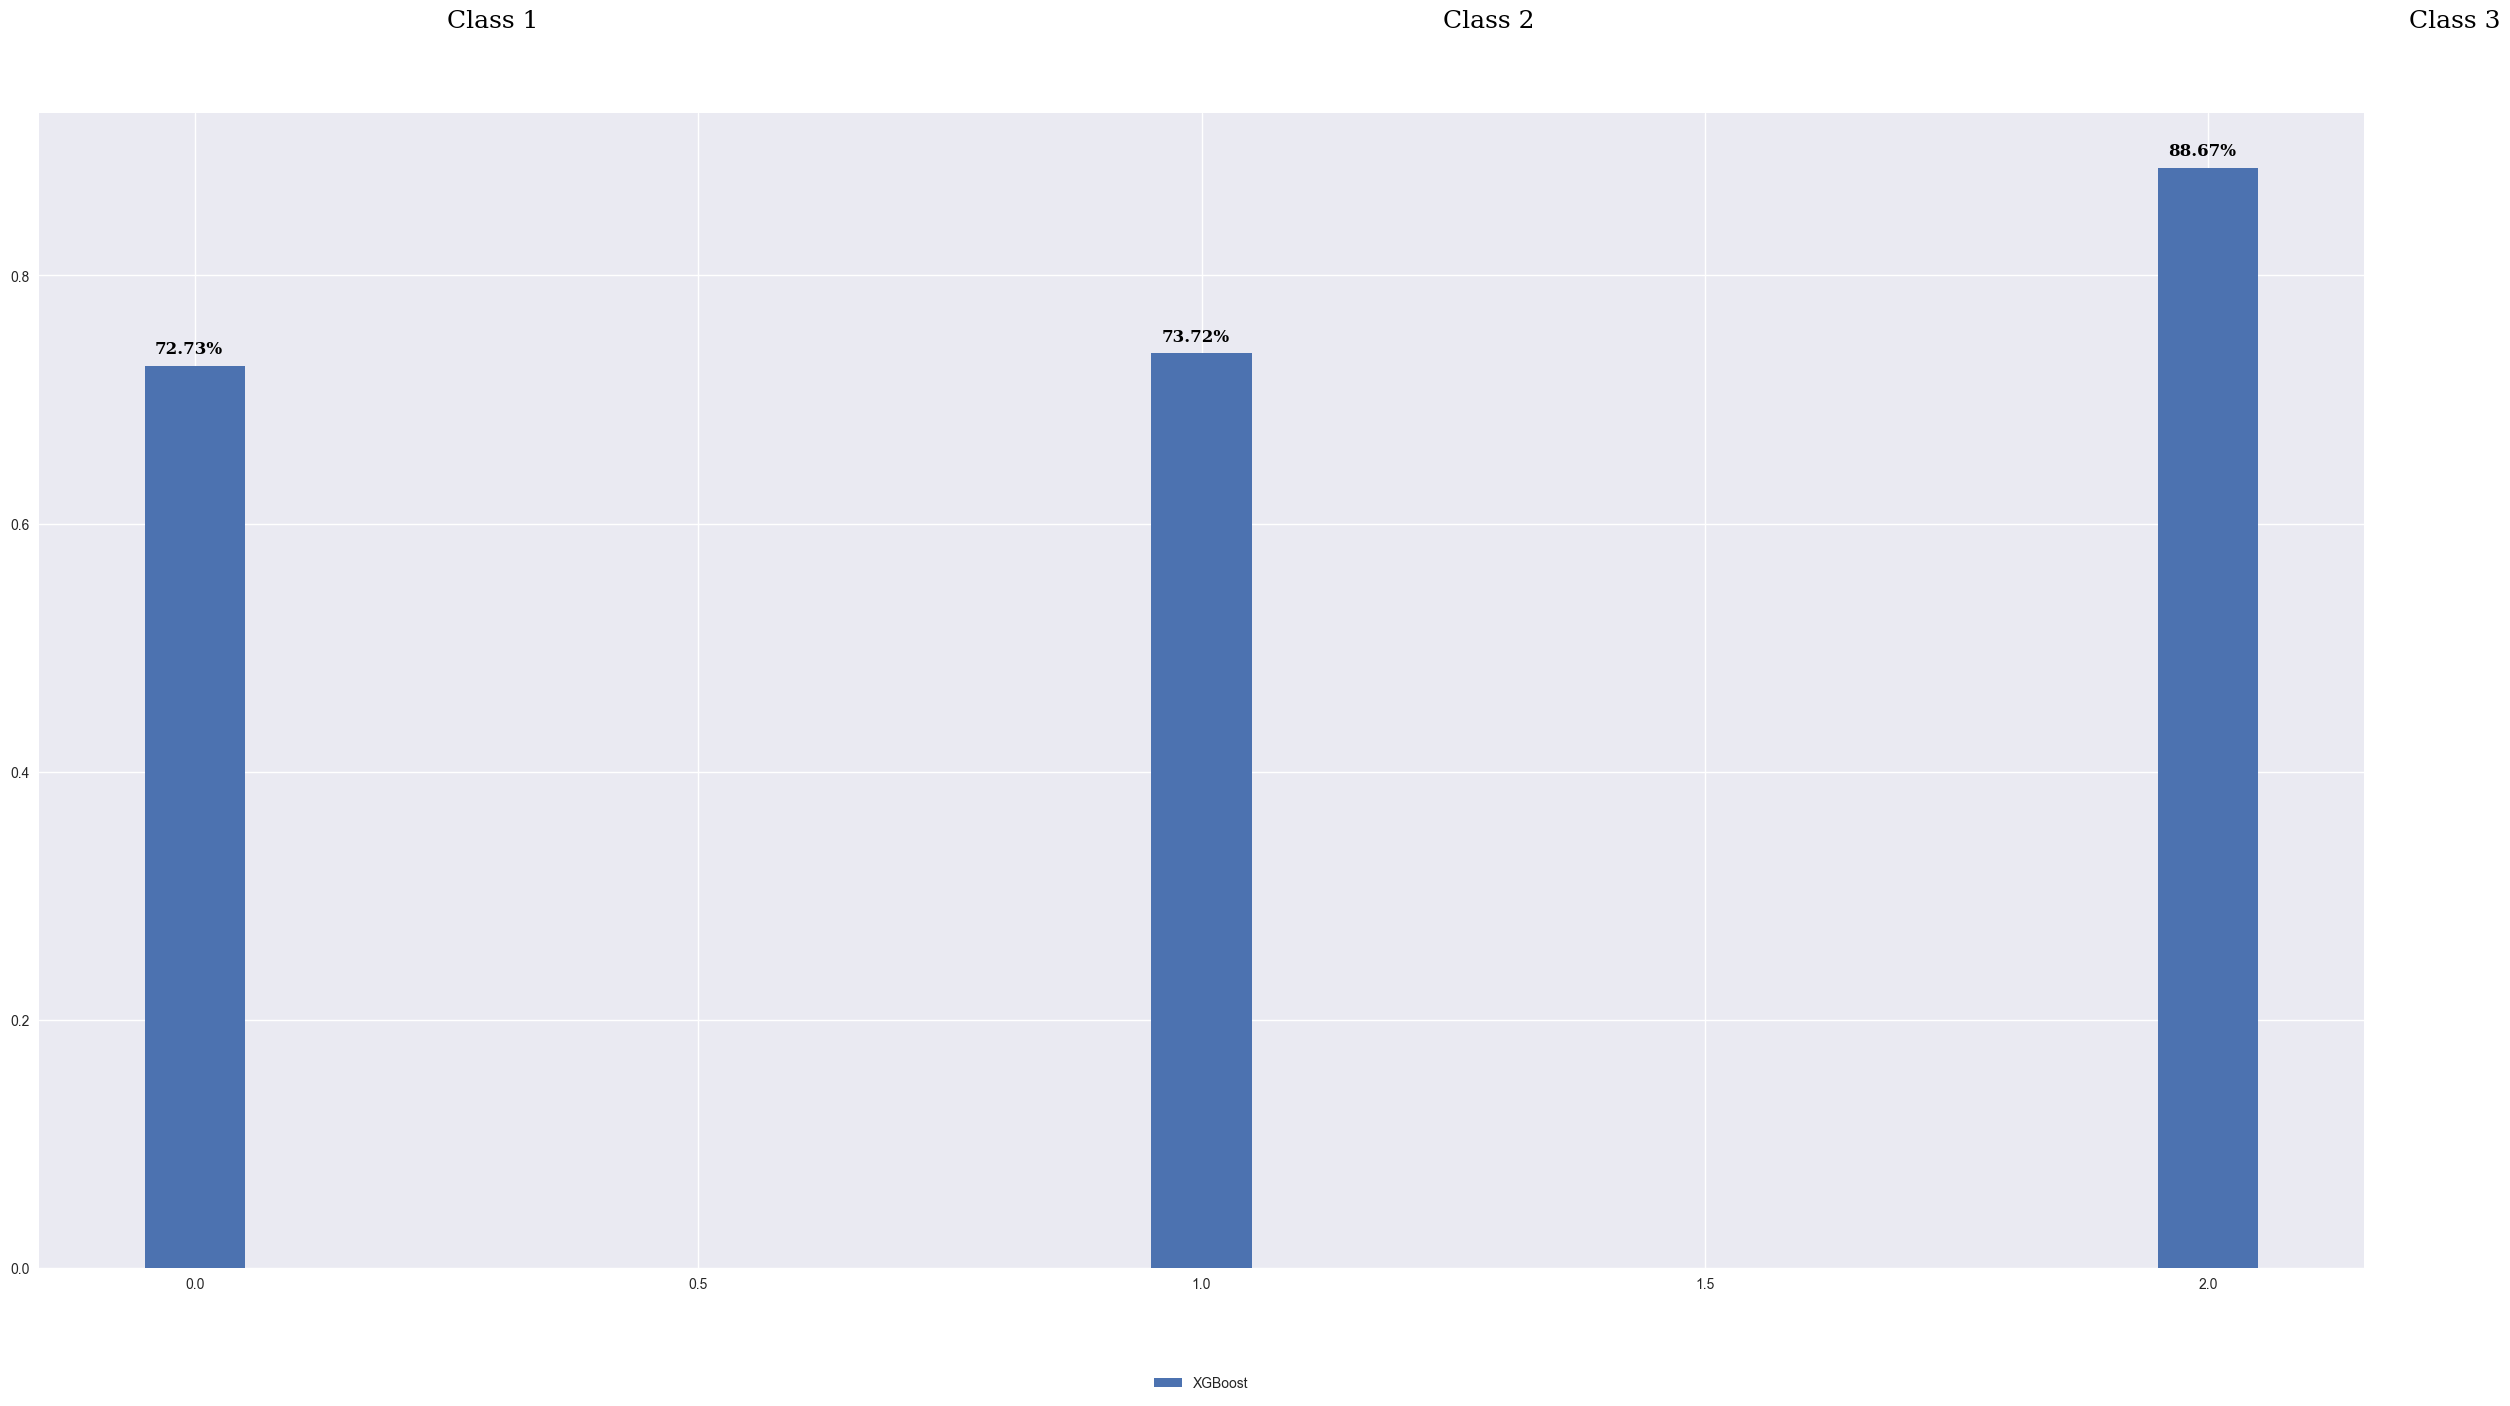

In [148]:
xg = [model_acc[0][0],model_acc[0][1],model_acc[0][2]]
print(model_acc)
font1 = {
    'family':'serif',
    'color':'black',
    'weight':'normal',
    'size':18
}
font2 = {
    'family':'serif',
    'color':'black',
    'weight':'bold',
    'size':12
}
x_ax = np.arange(3)
plt.figure(figsize=(30,15))
bar1 = plt.bar(x_ax,xg,width=0.1,align='center', label="XGBoost")

plt.text(0.25,1,'Class 1',fontdict=font1)
plt.text(1.24,1,'Class 2',fontdict=font1)
plt.text(2.2,1,'Class 3',fontdict=font1)
for bar in bar1.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)

plt.legend(loc='center', bbox_to_anchor=(0.5, -0.10), shadow=False, ncol=6)

plt.show()

# Bayes Network Classifier (Categorical Naive Bayes)

In [149]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'alpha': np.linspace(0.1,1,10),
    'fit_prior': [True, False],
}

In [150]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
scoring = 'accuracy'
grid_search = GridSearchCV(model, param_grid, scoring=scoring, cv=3, verbose=2)

In [151]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_dc_normalized_train = scaler.fit_transform(X_dc_train)
grid_search.fit(X_dc_normalized_train,y_dc_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END ..........................alpha=0.1, fit_prior=True; total time=   0.0s
[CV] END ..........................alpha=0.1, fit_prior=True; total time=   0.0s
[CV] END ..........................alpha=0.1, fit_prior=True; total time=   0.0s
[CV] END .........................alpha=0.1, fit_prior=False; total time=   0.0s
[CV] END .........................alpha=0.1, fit_prior=False; total time=   0.0s
[CV] END .........................alpha=0.1, fit_prior=False; total time=   0.0s
[CV] END ..........................alpha=0.2, fit_prior=True; total time=   0.0s
[CV] END ..........................alpha=0.2, fit_prior=True; total time=   0.0s
[CV] END ..........................alpha=0.2, fit_prior=True; total time=   0.0s
[CV] END .........................alpha=0.2, fit_prior=False; total time=   0.0s
[CV] END .........................alpha=0.2, fit_prior=False; total time=   0.0s
[CV] END .........................alpha=0.2, fit

GridSearchCV(cv=3, estimator=MultinomialNB(),
             param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'fit_prior': [True, False]},
             scoring='accuracy', verbose=2)

In [152]:
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best hyperparameters: {'alpha': 1.0, 'fit_prior': True}
Best score: 0.6862522759002271


In [153]:
best_mnb = grid_search.best_estimator_
m_nb =best_mnb.fit(X_dc_normalized_train,y_dc_train)

In [154]:
X_dc_normalized_test = scaler.fit_transform(X_dc_test)
y_pred = m_nb.predict(X_dc_test)
cm = confusion_matrix(y_dc_test, y_pred)
model_acc.append(cm.diagonal()/cm.sum(axis=1))

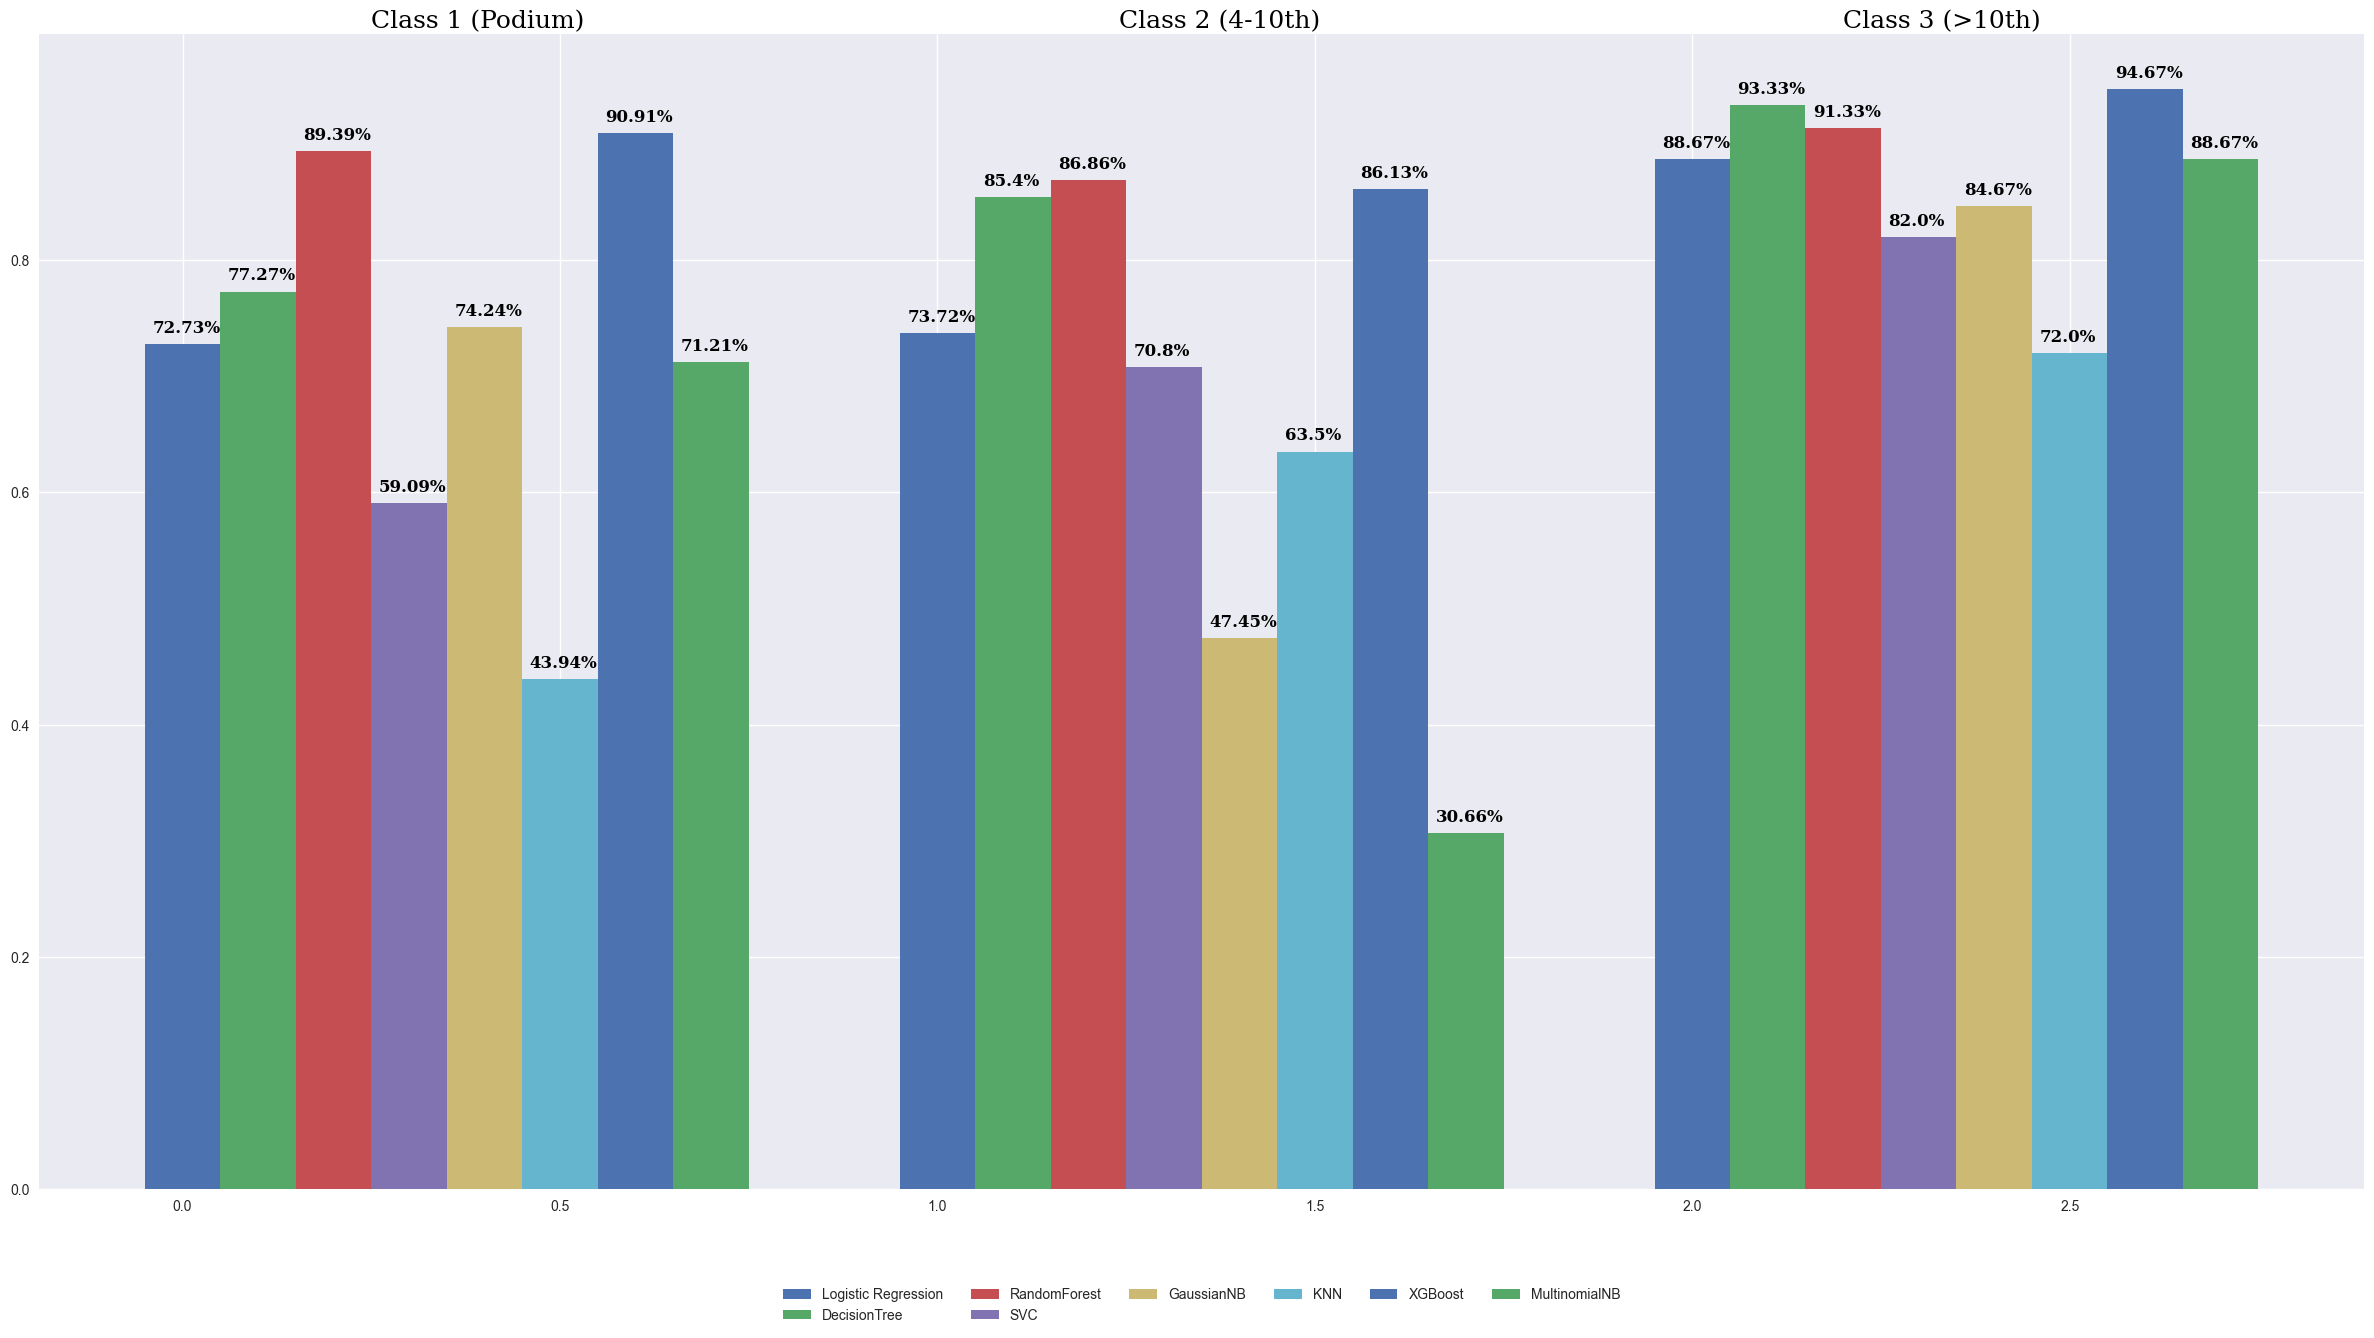

In [160]:
lr = [model_acc[0][0],model_acc[0][1],model_acc[0][2]]
dtc = [model_acc[1][0],model_acc[1][1],model_acc[1][2]]
rfc = [model_acc[2][0],model_acc[2][1],model_acc[2][2]]
svc = [model_acc[3][0],model_acc[3][1],model_acc[3][2]]
gnb = [model_acc[4][0],model_acc[4][1],model_acc[4][2]]
knn = [model_acc[5][0],model_acc[5][1],model_acc[5][2]]
xg =  [model_acc[6][0],model_acc[6][1],model_acc[6][2]]
mnb = [model_acc[7][0],model_acc[7][1],model_acc[7][2]]

font1 = {
    'family':'serif',
    'color':'black',
    'weight':'normal',
    'size':18
}
font2 = {
    'family':'serif',
    'color':'black',
    'weight':'bold',
    'size':12
}
x_ax = np.arange(3)
plt.figure(figsize=(30,15))
bar1 = plt.bar(x_ax,lr,width=0.1,align='center', label="Logistic Regression")
bar2 = plt.bar(x_ax+0.1,dtc,width=0.1,align='center', label="DecisionTree")
bar3 = plt.bar(x_ax+0.2,rfc,width=0.1,align='center',  label="RandomForest")
bar4 = plt.bar(x_ax+0.3,svc,width=0.1,align='center', label="SVC")
bar5 = plt.bar(x_ax+0.4,gnb,width=0.1,align='center', label="GaussianNB")
bar6 = plt.bar(x_ax+0.5,knn,width=0.1,align='center', label="KNN")
bar7 = plt.bar(x_ax+0.6,xg,width=0.1,align='center', label="XGBoost")
bar8 = plt.bar(x_ax+0.7,mnb,width=0.1,align='center', label="MultinomialNB")
plt.text(0.25,1,'Class 1 (Podium)',fontdict=font1)
plt.text(1.24,1,'Class 2 (4-10th)',fontdict=font1)
plt.text(2.2,1,'Class 3 (>10th)',fontdict=font1)
for bar in bar1.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar2.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar3.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar4.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar5.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar6.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar7.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar8.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.10), shadow=False, ncol=6)

plt.show()